# Prediction of aging parameters for partial data window

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [3]:
parameter_values.search("Li")

Cell cooling surface area [m2]	0.41
Initial plated lithium concentration [mol.m-3]	0.0
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Lithium interstitial reference concentration [mol.m-3]	15.0
Lithium metal partial molar volume [m3.mol-1]	1.3e-05
Typical lithium ion diffusivity [m2.s-1]	5.34e-10
Typical plated lithium concentration [mol.m-3]	1000.0


In [7]:
cell = 4

## Load eSOH Data and OCV Data

In [8]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 41, 82, 123, 164, 205, 246, 287


In [9]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " until 3V"
    # eps_n_data = 0.6234
    # eps_p_data = 0.4542
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"
elif cell_no=='04':
    c_rate_c = '1.5C'
    c_rate_d = '1.5C'
    dis_set = " until 3V"

In [10]:
dfe.N.iloc[-1]

287

In [11]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [12]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.n.L * param.n.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.p.L * param.p.c_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.p.c_max)

In [13]:
eps_p_data

0.434667923958085

In [14]:
parameter_values = get_parameter_values()
sim_des = '_highc'
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6/10,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5/10,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=2)

In [15]:
# print(all_sumvars_dict["cycles evaluated"])
# print(all_sumvars_dict["solution time"])

In [16]:
# fig = plot(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [17]:
# fig = plot1(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_cap_new.png')

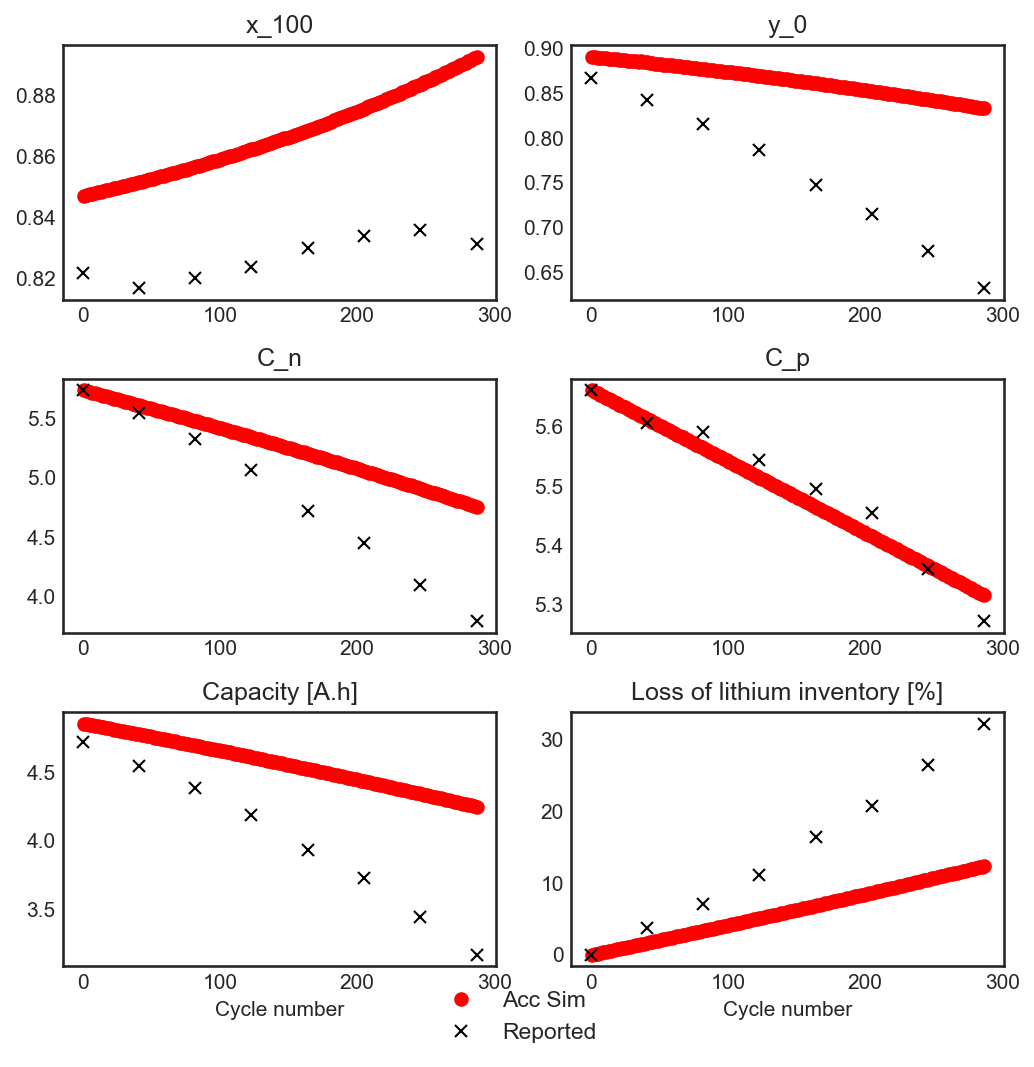

In [18]:
fig = plotc(all_sumvars_dict,dfe);

# Parameter Fitting

In [19]:
cycles = np.array(dfe['N'].astype('int'))
cycles=cycles-1
cycles[0]=cycles[0]+1
cycles
dfe['N_mod'] = cycles

In [20]:
def plot_comp(all_sumvars_dict_0,all_sumvars_dict_1,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(all_sumvars_dict_0["Cycle number"],all_sumvars_dict_0[name],"ro")
        # ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.axvline(x = all_sumvars_dict_0["Cycle number"][-1], color = 'm', label = 'axvline - full height')
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Pred"]+["Train"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5, -0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

## List of Initial Conditions

In [21]:
ic = 0
blam_p = [8e-7, 4e-6, 1e-5,1e-6]
blam_n = [5.5e-6, 3e-5, 2e-5,7e-5]
k_sei= [2e-16,1.5e-16,1.7e-16,1.3e-16]

In [22]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Cap"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    # variables = ["Capacity [A.h]", "C_n"]
    weights = [1,1,5,5]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,expt):
    parameter_values = get_parameter_values()
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]":  x[2]*k_sei[ic],
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "EC diffusivity [m2.s-1]": 2e-18,
            "Positive electrode LAM constant exponential term": 2,
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
        },
        check_already_exists=False,
    )
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    return cycle_adaptive_simulation(spm, parameter_values, expt,save_at_cycles=1)
def prediction_error(x,data,expt):
    try:
        model = simulate(x,expt,timeout=60)
        out = multi_objective(pd.DataFrame(model), data)
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out = 10*np.ones_like(np.concatenate([np.array(data['Cap'])]*4))
        print(f"x={x}, norm={np.linalg.norm(out)}")
        return out
    return out
def train_model(data,expt):
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0])
    # print(prediction_error(x0))
    soln_dfols = dfols.solve(prediction_error, x0,args=(data,expt), rhoend=1e-3)
    print(timer.time())
    return soln_dfols
def sim_train(dfe,experiment,df,train_len):
    data_train = dfe.iloc[:train_len]
    experiment_train = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *data_train.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    soln_dfols = train_model(data_train,experiment_train)
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['train_len'][train_len-3]=train_len
    df['x_0'][train_len-3]=round(xsol[0],4)
    df['x_1'][train_len-3]=round(xsol[1],4)
    df['x_2'][train_len-3]=round(xsol[2],4)
    # df['obj'][train_len-3]=soln_dfols.f
    try:
        sol_out = simulate(soln_dfols.x,experiment_train,timeout = 60)
        sol_full = simulate(soln_dfols.x,experiment,timeout = 60)
        df['obj'][train_len-3]= np.linalg.norm(prediction_error(soln_dfols.x,data_train,experiment_train))
        df['obj_full'][train_len-3] = np.linalg.norm(prediction_error(soln_dfols.x,dfe,experiment))
        fig = plot_comp(sol_out,sol_full,dfe);
        return df,fig
    except:
        print("Train Len = "+str(train_len)+" failed")
        fig, axes = plt.subplots(3,2,figsize=(7,7))
        return df,fig

In [23]:
df_x = pd.DataFrame(columns=['train_len','x_0','x_1','x_2','obj','obj_full'], index=range(len(N)+1-3))

In [24]:
len(N)

8

Train Length = 8
x=[1. 1. 1.], norm=2.3940241575464944
x=[1.1 1.  1. ], norm=2.4095144785647746
x=[1.  1.1 1. ], norm=2.2543462439585404
x=[1.  1.  1.1], norm=2.3786555395545155
x=[0.989812   1.19872482 1.0122317 ], norm=2.1199271700434013
x=[0.94959142 1.57363502 1.14574068], norm=1.7037300625794007
x=[0.89975316 1.8505583  2.72080564], norm=1.2609231870333988
x=[1.12658766 1.83598969 7.74596133], norm=0.403958675813584
x=[1.10372869 1.96900046 8.03443773], norm=0.279291785999372
x=[1.10099981 1.96357109 8.13680184], norm=0.27764469721395635
x=[1.80706645 2.1022989  8.10767118], norm=0.5470471931480752
x=[1.17060447 1.61031718 8.14158665], norm=0.8572860320971177
x=[1.09543119 1.96044395 7.98693786], norm=0.27962455649351986
x=[1.09920184 1.9642249  8.1483347 ], norm=0.2776268686126816
x=[1.09646607 1.94948217 8.14874398], norm=0.2798527325482446
x=[1.08463498 1.96686084 8.1459143 ], norm=0.27788525418568855
x=[1.09828745 1.96421035 8.1488636 ], norm=0.2776263294059259
x=[1.09800192 1

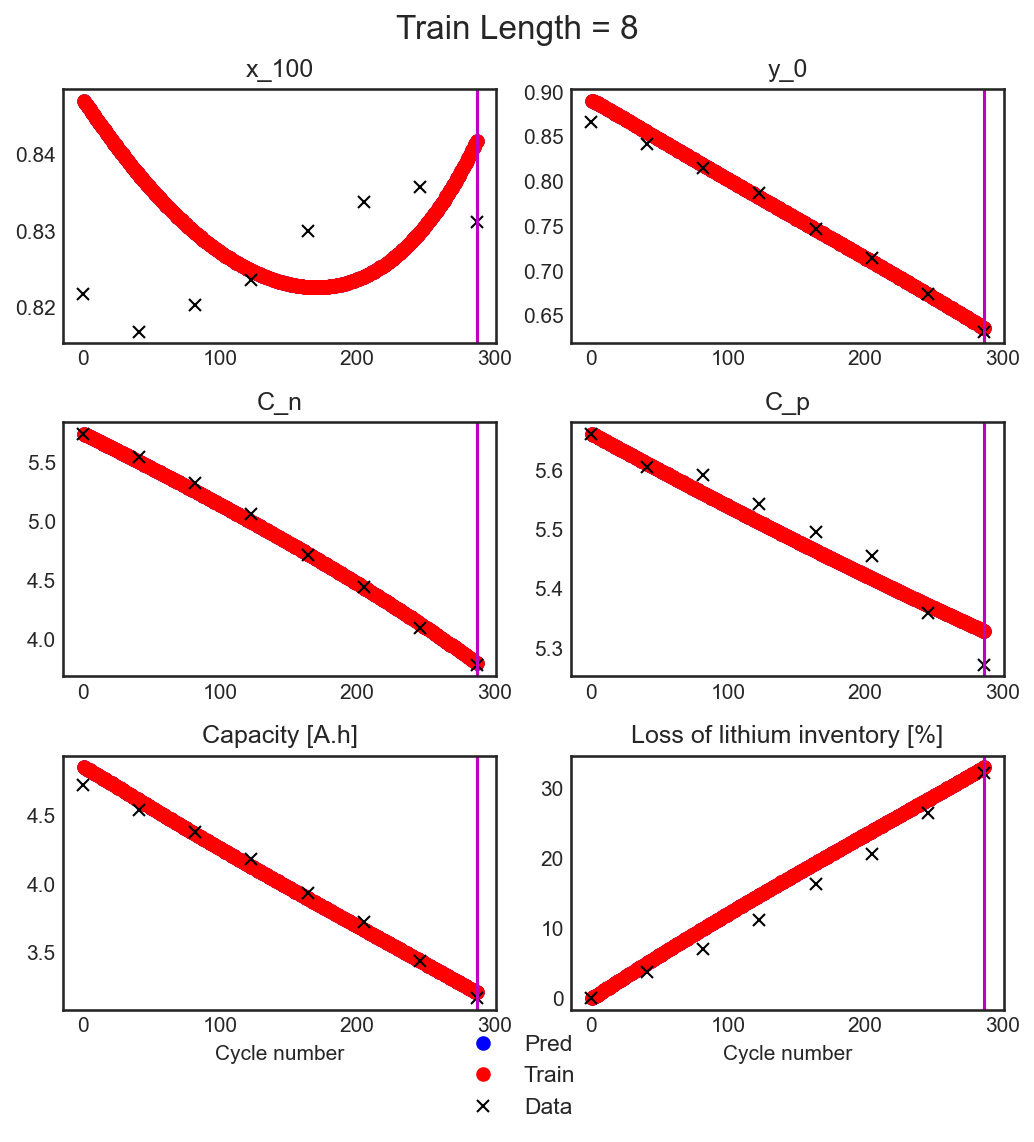

In [25]:
sim_des = "ic_"+str(ic)
timer1 = pybamm.Timer()
for train_len in [8]:
# for train_len in range(3,len(N)):
    print("Train Length = {0}".format(train_len))
    df_x,fig = sim_train(dfe,experiment,df_x,train_len)
    df_x.to_csv(res_DIR + "fit_train_pred_"+sim_des+".csv")
    fig.suptitle('Train Length = '+str(train_len),fontsize=16,y=1.02)
    fig.savefig(fig_DIR + "fit_train_pred_"+ sim_des+"_"+str(train_len) +"_eSOHC.png",bbox_inches='tight')
    print('Total Time')
    print(timer1.time())